Web scrapped data from Zara 

In [ ]:
import os
import ast
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
from tqdm import tqdm
import glob
import time
import random
import json

# Define directories
MEN_DIR = os.path.join(os.getcwd(), 'MEN')
IMAGES_DIR = os.path.join(os.getcwd(), 'images')  # Changed from img_cache to images

# Create the image directory if it doesn't exist
os.makedirs(IMAGES_DIR, exist_ok=True)
print(f"Image directory: {IMAGES_DIR}")

# Define image size
IMG_SIZE = (224, 224)  # Adjust as needed

# Test directory write permissions
test_file_path = os.path.join(IMAGES_DIR, "test.txt")
try:
    with open(test_file_path, 'w') as f:
        f.write("Test")
    os.remove(test_file_path)
    print("Directory is writable")
except Exception as e:
    print(f"WARNING: Directory write test failed: {e}")

# Process CSV files
all_csvs = glob.glob(os.path.join(MEN_DIR, '*.csv'))
print(f"Found {len(all_csvs)} CSV files")

data = []
labels = []
label_names = []

for csv_path in all_csvs:
    label = os.path.splitext(os.path.basename(csv_path))[0].replace('_', ' ').replace('-', ' ')
    # Remove labels that are not explicitly tied to clothing or do not have sufficient data
    if label.lower() in ['beauty', 'perfumes', 'accessories', 'bags backpacks', 'suits', 'linen', 'jeans']:
        continue  
    
    label_names.append(label)
    print(f"Processing {label} from {os.path.basename(csv_path)}")
    
    df = pd.read_csv(csv_path)
    processed_rows = 0
    
    for _, row in df.iterrows():
        img_list_str = row.get(' product_images') or row.get('product_images')
        if not isinstance(img_list_str, str) or not img_list_str.strip().startswith('['):
            continue
        
        try:
            img_list = ast.literal_eval(img_list_str)
            if not img_list or not isinstance(img_list, list):
                continue
                
            for img_dict in img_list:
                url = list(img_dict.keys())[0]
                data.append((url, label))
                labels.append(label)
                processed_rows += 1
        except Exception as e:
            pass
    
    print(f"  - Extracted {processed_rows} images from {label}")

# Create mapping of labels to indices
label_names = sorted(list(set(labels)))
label_to_idx = {name: i for i, name in enumerate(label_names)}
print(f"Found {len(label_names)} unique categories: {', '.join(label_names)}")
print(f"Total image URLs collected: {len(data)}")

# Create a log file
log_file = os.path.join(IMAGES_DIR, "download_log.txt")
with open(log_file, 'w') as f:
    f.write(f"Download started with {len(data)} images\n")

# Create status tracking files
status_file = os.path.join(IMAGES_DIR, "download_status.json")
invalid_urls_file = os.path.join(IMAGES_DIR, "invalid_urls.txt")

# Initialize status tracking
status = {
    "total_urls": len(data),
    "successful_downloads": 0,
    "failed_downloads": 0,
    "not_found_errors": 0,
    "forbidden_errors": 0,
    "other_errors": 0,
    "success_by_category": {label: 0 for label in label_names},
    "last_processed_index": 0
}

# Check if status file exists and load it to resume
if os.path.exists(status_file):
    try:
        with open(status_file, 'r') as f:
            saved_status = json.load(f)
            status.update(saved_status)
            print(f"Resuming from index {status['last_processed_index']} with {status['successful_downloads']} images already downloaded")
    except Exception as e:
        print(f"Error loading status file: {e}. Starting from scratch.")

# Initialize invalid URLs file if not exists
if not os.path.exists(invalid_urls_file):
    with open(invalid_urls_file, 'w') as f:
        f.write("# List of invalid URLs\n")

# User agent list to rotate
user_agents = [
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
    'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.107 Safari/537.36',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:90.0) Gecko/20100101 Firefox/90.0',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.0 Safari/605.1.15',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.212 Safari/537.36'
]

# Referrers to rotate
referrers = [
    'https://www.zara.com/us/',
    'https://www.zara.com/us/en/man-shirts-l737.html',
    'https://www.zara.com/us/en/man-jeans-l659.html',
    'https://www.zara.com/',
    'https://www.google.com/'
]

# Download images with improved error handling
img_paths = []
y = []
error_types = {}

# Start from the last processed index for resuming
start_idx = status["last_processed_index"]
data_to_process = data[start_idx:]

for idx, (url, label) in enumerate(tqdm(data_to_process, desc='Downloading images')):
    # Calculate the actual index in the original data list
    actual_idx = idx + start_idx
    img_filename = os.path.join(IMAGES_DIR, f'{label}_{actual_idx}.jpg')
    
    # Update the last processed index in status
    status["last_processed_index"] = actual_idx
    
    # Save status periodically
    if actual_idx % 10 == 0:
        with open(status_file, 'w') as f:
            json.dump(status, f, indent=2)
    
    if not os.path.exists(img_filename):
        try:
            # Add delay between requests (important to avoid blocking)
            time.sleep(random.uniform(1.0, 3.0))
            
            # For debug purposes, print every 50th URL
            if idx % 50 == 0:
                print(f"Downloading {actual_idx}: {url[:60]}...")
                
            # Create headers that mimic a real browser
            headers = {
                'User-Agent': random.choice(user_agents),
                'Accept': 'image/avif,image/webp,image/apng,image/svg+xml,image/*,*/*;q=0.8',
                'Accept-Language': 'en-US,en;q=0.9',
                'Referer': random.choice(referrers),
                'Connection': 'keep-alive',
                'Cache-Control': 'max-age=0',
                'sec-ch-ua': '"Google Chrome";v="91", " Not;A Brand";v="99", "Chromium";v="91"',
                'sec-ch-ua-mobile': '?0',
                'sec-fetch-dest': 'image',
                'sec-fetch-mode': 'no-cors',
                'sec-fetch-site': 'same-origin',
            }
            
            # Download the image with headers
            r = requests.get(url, headers=headers, timeout=15)
            r.raise_for_status()
            
            # Validate that we received image data
            content_type = r.headers.get('Content-Type', '')
            if not content_type.startswith('image/'):
                raise ValueError(f"Content is not an image: {content_type}")
                
            # Process and save the image
            img = Image.open(BytesIO(r.content)).convert('RGB')
            img = img.resize(IMG_SIZE)
            img.save(img_filename)
            
            # Update success counters
            status["successful_downloads"] += 1
            status["success_by_category"][label] = status["success_by_category"].get(label, 0) + 1
            
            # Log progress periodically
            if status["successful_downloads"] % 20 == 0:
                print(f"Successfully downloaded {status['successful_downloads']} images so far")
                with open(log_file, 'a') as f:
                    f.write(f"Downloaded {status['successful_downloads']} images\n")
                    
        except requests.exceptions.HTTPError as e:
            status["failed_downloads"] += 1
            
            # Categorize HTTP errors
            if e.response.status_code == 404:
                status["not_found_errors"] += 1
                error_status = "NOT_FOUND (404)"
                
                # Record invalid URL
                with open(invalid_urls_file, 'a') as f:
                    f.write(f"{url}\n")
                
                # Try an alternative URL format
                alt_url = None
                if '/w/0/' in url:
                    alt_url = url.replace('/w/0/', '/w/448/')
                elif '/w/448/' in url:
                    alt_url = url.replace('/w/448/', '/w/0/')
                
                if alt_url:
                    try:
                        # Try the alternative URL
                        time.sleep(random.uniform(1.0, 2.0))
                        r = requests.get(alt_url, headers=headers, timeout=15)
                        r.raise_for_status()
                        
                        # Validate that we received image data
                        content_type = r.headers.get('Content-Type', '')
                        if not content_type.startswith('image/'):
                            raise ValueError(f"Content is not an image: {content_type}")
                            
                        # Process and save the image
                        img = Image.open(BytesIO(r.content)).convert('RGB')
                        img = img.resize(IMG_SIZE)
                        img.save(img_filename)
                        
                        # Update success counters
                        status["successful_downloads"] += 1
                        status["success_by_category"][label] = status["success_by_category"].get(label, 0) + 1
                        
                        # Log the recovery
                        print(f"Recovered 404 image using alternative URL: {alt_url[:60]}...")
                        with open(log_file, 'a') as f:
                            f.write(f"Recovered URL {url} with alternative {alt_url}\n")
                            
                        # Continue to next image
                        img_paths.append(img_filename)
                        y.append(label_to_idx[label])
                        continue
                        
                    except Exception:
                        # If alternative URL also fails, continue with the error handling
                        pass
                        
            elif e.response.status_code == 403:
                status["forbidden_errors"] += 1
                error_status = "FORBIDDEN (403)"
            else:
                status["other_errors"] += 1
                error_status = f"HTTP_ERROR ({e.response.status_code})"
                
            # Log HTTP errors
            print(f"Error ({error_status}) with {url}: {str(e)}")
            with open(log_file, 'a') as f:
                f.write(f"Error ({error_status}) with {url}: {str(e)}\n")
                
            continue
            
        except Exception as e:
            # Handle other types of errors
            status["failed_downloads"] += 1
            status["other_errors"] += 1
            error_type = type(e).__name__
            error_types[error_type] = error_types.get(error_type, 0) + 1
            
            # Only print the first few errors of each type
            if error_types[error_type] <= 5:
                print(f"Error ({error_type}) with {url}: {str(e)}")
                
            # Log errors
            with open(log_file, 'a') as f:
                f.write(f"Error ({error_type}) with {url}: {str(e)}\n")
                
            continue
    else:
        # Image already exists
        status["successful_downloads"] += 1
        status["success_by_category"][label] = status["success_by_category"].get(label, 0) + 1
        
    img_paths.append(img_filename)
    y.append(label_to_idx[label])

    # Update status after every 10 images
    if actual_idx % 10 == 0:
        with open(status_file, 'w') as f:
            json.dump(status, f, indent=2)

# Final status save
with open(status_file, 'w') as f:
    json.dump(status, f, indent=2)

# Create a detailed status summary
status_summary = os.path.join(IMAGES_DIR, "status_summary.txt")
with open(status_summary, 'w') as f:
    f.write("=== DOWNLOAD STATUS SUMMARY ===\n\n")
    f.write(f"Total URLs: {status['total_urls']}\n")
    f.write(f"Successfully downloaded: {status['successful_downloads']} ({status['successful_downloads']/status['total_urls']*100:.2f}%)\n")
    f.write(f"Failed downloads: {status['failed_downloads']} ({status['failed_downloads']/status['total_urls']*100:.2f}%)\n\n")
    
    f.write("Failure details:\n")
    f.write(f"  - Not Found (404) errors: {status['not_found_errors']}\n")
    f.write(f"  - Forbidden (403) errors: {status['forbidden_errors']}\n")
    f.write(f"  - Other errors: {status['other_errors']}\n\n")
    
    f.write("Downloads by category:\n")
    for label, count in status["success_by_category"].items():
        total_in_category = sum(1 for _, l in data if l == label)
        if total_in_category > 0:
            success_rate = count / total_in_category * 100
            f.write(f"  - {label}: {count}/{total_in_category} ({success_rate:.2f}%)\n")

# Print summary to console
print(f"\nDownload summary:")
print(f"  - Total URLs: {status['total_urls']}")
print(f"  - Successfully downloaded: {status['successful_downloads']} ({status['successful_downloads']/status['total_urls']*100:.2f}%)")
print(f"  - Failed downloads: {status['failed_downloads']} ({status['failed_downloads']/status['total_urls']*100:.2f}%)")
print(f"  - Not Found (404) errors: {status['not_found_errors']}")
print(f"  - Forbidden (403) errors: {status['forbidden_errors']}")
print(f"  - Other errors: {status['other_errors']}")
print(f"  - Images in final dataset: {len(img_paths)}")
print(f"\nDetailed summary saved to: {status_summary}")
print(f"Invalid URLs saved to: {invalid_urls_file}")

# Write summary to log
with open(log_file, 'a') as f:
    f.write(f"\n--- FINAL SUMMARY ---\n")
    f.write(f"Total URLs: {status['total_urls']}\n")
    f.write(f"Successfully downloaded: {status['successful_downloads']}\n")
    f.write(f"Failed downloads: {status['failed_downloads']}\n")
    f.write(f"Not Found (404) errors: {status['not_found_errors']}\n")
    f.write(f"Forbidden (403) errors: {status['forbidden_errors']}\n")
    f.write(f"Other errors: {status['other_errors']}\n")
    f.write(f"Images in final dataset: {len(img_paths)}\n")

# If no images were downloaded, print a more detailed error
if status["successful_downloads"] == 0:
    print("\nNo images were successfully downloaded! Possible issues:")
    print("1. URL format may be incorrect")
    print("2. Network connectivity issues")
    print("3. Permission issues with the images directory")
    print("4. The URLs might not be pointing to valid images")
    
    # Try to save a simple test image to check directory permissions
    try:
        # Create a small blank image
        test_img = Image.new('RGB', (10, 10), color='red')
        test_path = os.path.join(IMAGES_DIR, 'test_image.jpg')
        test_img.save(test_path)
        print(f"Successfully created test image at: {test_path}")
    except Exception as e:
        print(f"Failed to create test image: {e}")

# Create a dataset metadata file
dataset_metadata = os.path.join(IMAGES_DIR, "dataset_metadata.json")
with open(dataset_metadata, 'w') as f:
    json.dump({
        "total_images": len(img_paths),
        "categories": label_names,
        "label_to_idx": label_to_idx,
        "category_counts": status["success_by_category"],
        "download_date": time.strftime("%Y-%m-%d %H:%M:%S")
    }, f, indent=2)

print(f"\nDataset metadata saved to: {dataset_metadata}")
print("Download process complete!")

# PART 1: DATA PREPROCESSING

The data preprocessing stage began with web scraping clothing images from Zara, which were downloaded and organized by category. A crucial step involved mapping original fine-grained labels to four broad clothing categories for more effective classification. All images were processed by resizing to a consistent 160x160 pixel dimension, converting to RGB format, and normalizing pixel values by dividing by 255.0. The raw category labels were mapped to four unified categories (Athletic, Bottoms, Natural, and Tops) and encoded numerically using a label-to-index dictionary. To prepare the data for training, an 80/20 train-test split was implemented with stratification to maintain class distribution across sets. Data augmentation techniques were applied through ImageDataGenerator, including rotation, width and height shifts, horizontal flipping, and zoom variation to artificially expand the training dataset. The final dataset contained 1,664 images with a notable imbalance: 182 Athletic, 406 Bottoms, 24 Natural, and 1,052 Tops images

In [48]:
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [49]:
# Enable mixed precision for faster training
try:
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print("Mixed precision enabled")
except:
    print("Mixed precision not available")

Mixed precision enabled


In [50]:
# Parameters!
IMG_SIZE = (160, 160)  
BATCH_SIZE = 32
EPOCHS = 10 
IMAGES_DIR = '/Users/jennifertran/Desktop/Spring PT 2 2025/DeepLearning/FinalProject/images'

In [51]:
# mapping from original labels to 5 categories
category_mapping = {
    'T SHIRTS': 'Tops',
    'POLO SHIRTS': 'Tops',
    'SHIRTS': 'Tops',
    
    'BLAZERS': 'Tops',
    'HOODIES SWEATSHIRTS': 'Tops',
    'OVERSHIRTS': 'Tops',
    'SWEATERS CARDIGANS': 'Tops',
    
    'TROUSERS': 'Bottoms',
    'JEANS': 'Bottoms',
    'SHORTS': 'Bottoms',
    
    'ZARA ATHLETICZ': 'Athletic',
    'SWIMWEAR': 'Athletic',
    
    'ZARA ORIGINS': 'Natural',
    'LINEN': 'Natural'
}

In [52]:
# Load all image paths from the directory
img_paths = []
for filename in os.listdir(IMAGES_DIR):
    if filename.endswith('.jpg') and not filename.startswith('.'):
        img_paths.append(os.path.join(IMAGES_DIR, filename))

#putting it all in batches to make it faster
X = []
y = []
labels = []

for path in tqdm(img_paths, desc='Loading images'):
    try:
        filename = os.path.basename(path)
        parts = filename.split('_')
        if len(parts) > 1:
            original_label = '_'.join(parts[:-1])
            if original_label in category_mapping:
                img = Image.open(path).convert('RGB')
                img = img.resize(IMG_SIZE)
                X.append(np.array(img))
                labels.append(category_mapping[original_label])
    except Exception as e:
        continue

Loading images: 100%|██████████| 2125/2125 [00:01<00:00, 1271.24it/s]


In [53]:
# Convert labels to indices
unique_labels = sorted(list(set(labels)))
label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
y = np.array([label_to_idx[label] for label in labels])
X = np.array(X) / 255.0  

In [54]:
#num of images:
len(X),unique_labels

(1664, ['Athletic', 'Bottoms', 'Natural', 'Tops'])

In [55]:
for label in unique_labels:
    count = labels.count(label)
    print(f"{label}: {count} images")

Athletic: 182 images
Bottoms: 406 images
Natural: 24 images
Tops: 1052 images


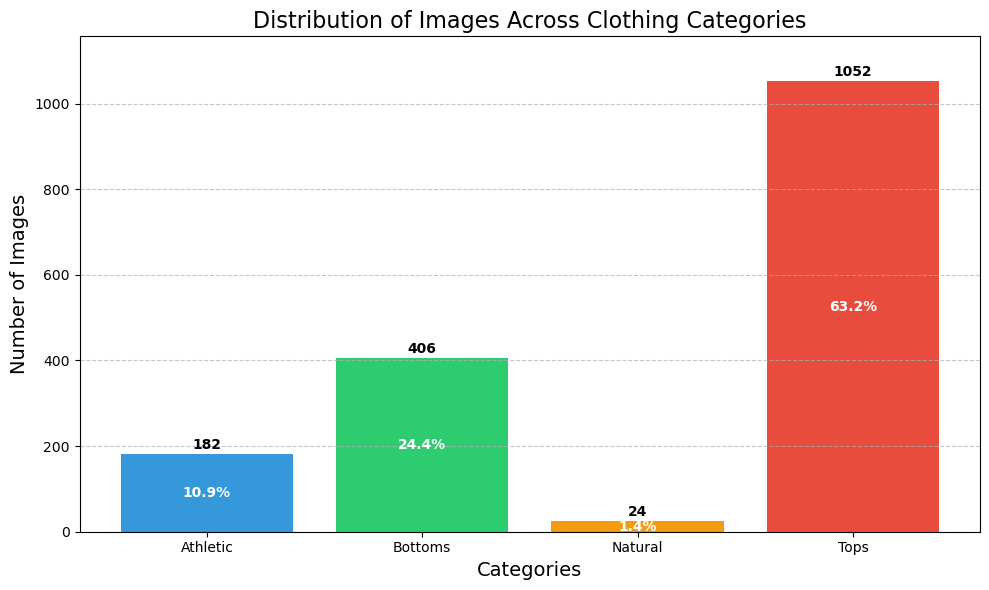

In [68]:
category_counts = [labels.count(label) for label in unique_labels]

plt.figure(figsize=(10, 6))
bars = plt.bar(unique_labels, category_counts, color=['#3498db', '#2ecc71', '#f39c12', '#e74c3c'])

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
            f'{height}', ha='center', va='bottom', fontweight='bold')

plt.title('Distribution of Images Across Clothing Categories', fontsize=16)
plt.xlabel('Categories', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, max(category_counts) * 1.1)

total = sum(category_counts)
for bar in bars:
    height = bar.get_height()
    percentage = height / total * 100
    plt.text(bar.get_x() + bar.get_width()/2., height/2,
            f'{percentage:.1f}%', ha='center', va='center', 
            fontweight='bold', color='white')

plt.tight_layout()
plt.show()


# PART 2: MODEL IMPLEMENTATION 


We wanted to focus on efficienct and optimization through a transfer learning approach. MobileNetV2 was selected as the base model with pre-trained ImageNet weights due to its excellent balance of performance and efficiency on limited computational resources aka our computers. The base model layers were frozen to leverage the feature extraction capabilities already learned from ImageNet, allowing the model to adapt to clothing classification with minimal training. The architecture included the MobileNetV2 base followed by a Global Average Pooling layer to reduce spatial dimensions, a dense layer with 128 units and ReLU activation, a dropout layer (0.5) for regularization, and finally an output layer with softmax activation for 4-class prediction. Mixed precision training was enabled for faster computation, with Adam optimizer (learning rate 0.001) and sparse categorical crossentropy loss function. The implementation leveraged TensorFlow/Keras for model construction, with a modular function approach for easy initialization and efficient batch processing during training.


In [ ]:
def create_fast_model(input_shape, num_classes):
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    base_model.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x) 
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [57]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

# PART 3: METHODS AND EXPERIMENTS 


The methodological approach was centered on effective training and evaluation strategies tailored to the clothing classification task. Transfer learning was employed using the pre-trained MobileNetV2 model to overcome the limitations of the relatively small dataset. Early stopping with a patience of 3 was implemented to prevent overfitting, automatically terminating training when validation loss stopped improving. Data augmentation was utilized during training to improve generalization by creating variations of the training images. Training was limited to 10 epochs maximum, with early termination based on validation loss performance. Key hyperparameters included a batch size of 32 for efficient GPU utilization, learning rate of 0.001, image size of 160x160 pixels (balancing detail and computational efficiency), and dropout rate of 0.5 to reduce overfitting. The evaluation approach used a stratified train-test split to ensure representative class distribution, with continuous monitoring of validation accuracy and loss during training. After training, a classification report was generated for detailed performance metrics across categories, and a confusion matrix was created to analyze misclassification patterns.


In [58]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [59]:
model = create_fast_model(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    num_classes=len(unique_labels)
)

In [60]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,  
    restore_best_weights=True
)

In [61]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=min(len(X_train) // BATCH_SIZE, 10),  # Limit steps for each epoc
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10


/Users/jennifertran/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.2756 - loss: 2.1589 - val_accuracy: 0.6637 - val_loss: 1.0674
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 918ms/step - accuracy: 0.6800 - loss: 1.1649 - val_accuracy: 0.7267 - val_loss: 0.6916
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 721ms/step - accuracy: 0.6968 - loss: 0.8991 - val_accuracy: 0.7568 - val_loss: 0.6135
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 718ms/step - accuracy: 0.7912 - loss: 0.5772 - val_accuracy: 0.7508 - val_loss: 0.5961
Epoch 5/10
 2/10 ━━━━━━━━━━━━━━━━━━━━ 2s 273ms/step - accuracy: 0.7188 - loss: 0.7165

/Users/jennifertran/anaconda3/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.7437 - loss: 0.6796 - val_accuracy: 0.7538 - val_loss: 0.5999
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 571ms/step - accuracy: 0.7698 - loss: 0.5976 - val_accuracy: 0.7447 - val_loss: 0.6781
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 700ms/step - accuracy: 0.8264 - loss: 0.6180 - val_accuracy: 0.7688 - val_loss: 0.5917
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 638ms/step - accuracy: 0.7419 - loss: 0.6686 - val_accuracy: 0.7868 - val_loss: 0.5738
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 638ms/step - accuracy: 0.7880 - loss: 0.6071 - val_accuracy: 0.7838 - val_loss: 0.5425
Epoch 10/10
 2/10 ━━━━━━━━━━━━━━━━━━━━ 2s 323ms/step - accuracy: 0.7578 - loss: 0.6223

2025-05-11 22:48:56.225916: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 464ms/step - accuracy: 0.7641 - loss: 0.6275 - val_accuracy: 0.7778 - val_loss: 0.5410


# PART 4: RESULTS AND VISUALIZATION


In [62]:
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=1)
val_acc 

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 342ms/step - accuracy: 0.7700 - loss: 0.5700


0.7777777910232544

In [63]:
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)


11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 483ms/step


In [64]:
report = classification_report(
    y_val,
    y_pred_classes,
    target_names=unique_labels,
    output_dict=False
)
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

    Athletic       0.73      0.61      0.67        36
     Bottoms       0.66      0.60      0.63        81
     Natural       0.00      0.00      0.00         5
        Tops       0.82      0.89      0.85       211

    accuracy                           0.78       333
   macro avg       0.55      0.53      0.54       333
weighted avg       0.76      0.78      0.77       333



/Users/jennifertran/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jennifertran/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jennifertran/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

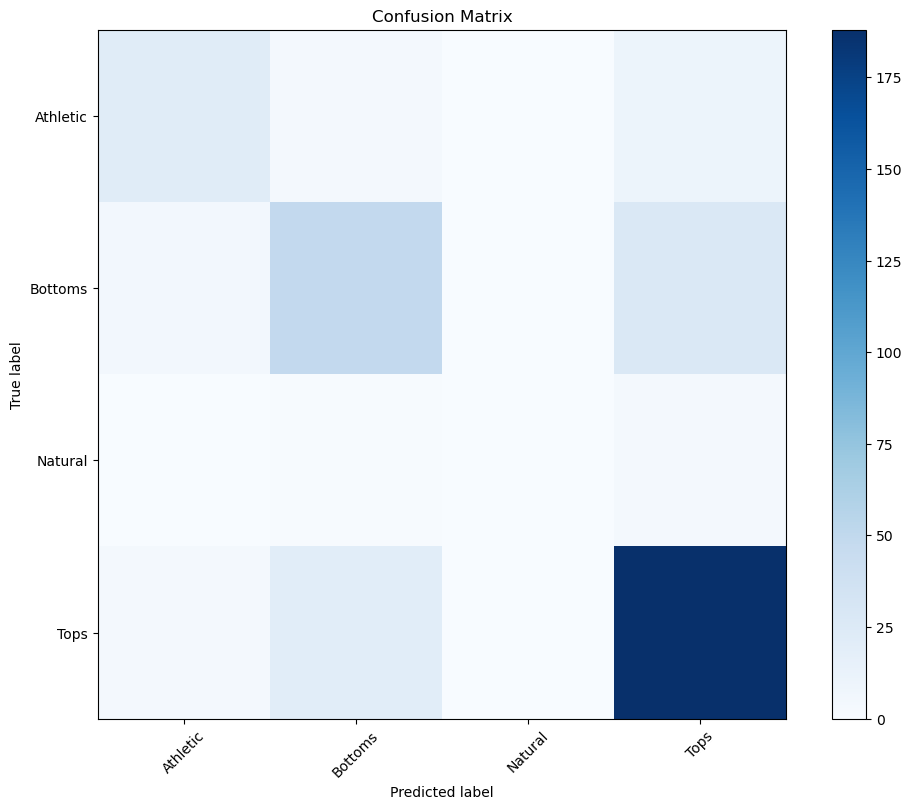

In [65]:
# Confusion matrix
cm = confusion_matrix(y_val, y_pred_classes)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(unique_labels))
plt.xticks(tick_marks, unique_labels, rotation=45)
plt.yticks(tick_marks, unique_labels)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

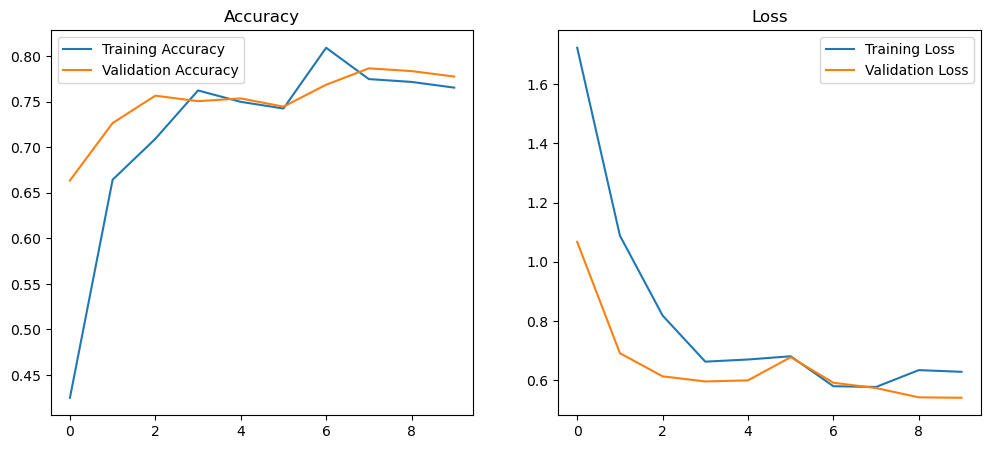

In [66]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [67]:
model.save("clothesclassificationmodel.h5")


The methodological approach centered on effective training and evaluation strategies tailored to the clothing classification task. Transfer learning was employed using the pre-trained MobileNetV2 model to overcome the limitations of the relatively small dataset. Early stopping with a patience of 3 was implemented to prevent overfitting, automatically terminating training when validation loss stopped improving. Data augmentation was utilized during training to improve generalization by creating variations of the training images. Training was limited to 10 epochs maximum, with early termination based on validation loss performance. Key hyperparameters included a batch size of 32 for efficient GPU utilization, learning rate of 0.001, image size of 160x160 pixels (balancing detail and computational efficiency), and dropout rate of 0.5 to reduce overfitting. The evaluation approach used a stratified train-test split to ensure representative class distribution, with continuous monitoring of validation accuracy and loss during training. After training, a classification report was generated for detailed performance metrics across categories, and a confusion matrix was created to analyze misclassification patterns.
